In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import lightgbm as lgb
import re
import timeit
import random
random.seed(3)

In [2]:
# Import the train data
train = pd.read_csv('datasets/SUPCOM_Train.csv')

# Import the test data
test = pd.read_csv('datasets/SUPCOM_Test.csv')

Submission = pd.read_csv('datasets/SUPCOM_SampleSubmission.csv')
variables = pd.read_csv('datasets/VariableDescription.csv')

In [3]:
#excel = pd.read_excel("datasets/train_data.xlsx")

In [4]:
#excel.head()

In [3]:
target = train.target.values
print(target.shape)

(21295,)


In [4]:
# Combine train and test data for easy preprocessing
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test),sort=False)
print(data.shape)
data.head()

(28812, 121)


,BCT_CODBUR,CTR_MATFIS,CTR_CATEGO_X,FJU_CODFJU,CTR_CESSAT,ACT_CODACT,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,...,target,FAC_MNTPRI_F,FAC_MFODEC_F,FAC_MNTDCO_F,FAC_MNTTVA_F,FAC_MNTPRI_C,FAC_MFODEC_C,FAC_MNTDCO_C,FAC_MNTTVA_C,id
0,44,6210,C,99,0,3707,4,2,2,2,...,16.639203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_id17437
1,401,14383,M,22,0,6105,4,2,2,2,...,17.827703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_id5086
2,243,11555,M,23,0,5751,4,2,2,2,...,15.473503,25387000.0,0.0,0.0,4571280.0,NaN,NaN,NaN,NaN,train_id1443
3,72,6175,C,99,0,4402,4,2,2,2,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_id15469
4,42,1417,M,23,0,6302,4,2,2,2,...,14.286244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train_id14368


In [5]:
variables.head(60)

,Libellé,Intitulé,Title
0,Contribuable,NaN,Rate payer
1,BCT_CODBUR,Code Bureau de contrôle des impôts,Code Tax Control Office
2,CTR_MATFIS,ID Contribuable,Rate payer ID
3,CTR_CATEGO_x,Catégorie Contribuable,Rate payer category
4,CTR_CODTVA,Code TVA,Code TVA
5,FJU_CODFJU,Code Forme Juridique,Code Legal Form
6,CTR_CESSAT,"Code Cessation (0 : Actif, 1 : en cessation)","Cessation Code (0: Active, 1: Inactive)"
7,ACT_CODACT,Code Activité,Activity Code
8,CTR_OBLDIR,Obligation,Obligation
9,CTR_OBLACP,Obligation Acompte Provisionnel,Provisional Down Payment Obligation


In [6]:
variables.tail(60)

,Libellé,Intitulé,Title
97,SND_MNTDRC_E,Montant Droit de Consommation à l'Exportation,Amount of Export Consumption Right
98,SND_MNTAVA_E,Montant Avance à l'Exportation,Amount Advance for Export
99,SND_MNTTAX_E,Montant Autres Taxes Payés à l'Exportation,Amount Other Taxes Paid for Exportation\n
100,SND_MNTPAY_E,Montant Total Payé à l'Exportation,Montant Total Payé à l'Exportation
101,SND_MNTAIR_E,NaN,NaN
102,SND_MNTPRD_A,Montant Produit autres régimes,Amount Product other plans
103,SND_MNTTVA_A,Montant TVA autres régimes,VAT amount other schemes
104,SND_MNTDRC_A,Montant Droit de Consommation autres régimes,Amount Consumer Right other plans
105,SND_MNTAVA_A,Montant Avance autres régimes,Amount Advance other plans
106,SND_MNTTAX_A,Montant Autres Taxes Payés autres régimes,Amount Other Taxes Paid other plans


In [7]:
data.columns

Index(['BCT_CODBUR', 'CTR_MATFIS', 'CTR_CATEGO_X', 'FJU_CODFJU', 'CTR_CESSAT',
       'ACT_CODACT', 'CTR_OBLDIR', 'CTR_OBLACP', 'CTR_OBLRES', 'CTR_OBLFOP',
       ...
       'target', 'FAC_MNTPRI_F', 'FAC_MFODEC_F', 'FAC_MNTDCO_F',
       'FAC_MNTTVA_F', 'FAC_MNTPRI_C', 'FAC_MFODEC_C', 'FAC_MNTDCO_C',
       'FAC_MNTTVA_C', 'id'],
      dtype='object', length=121)

<AxesSubplot:>

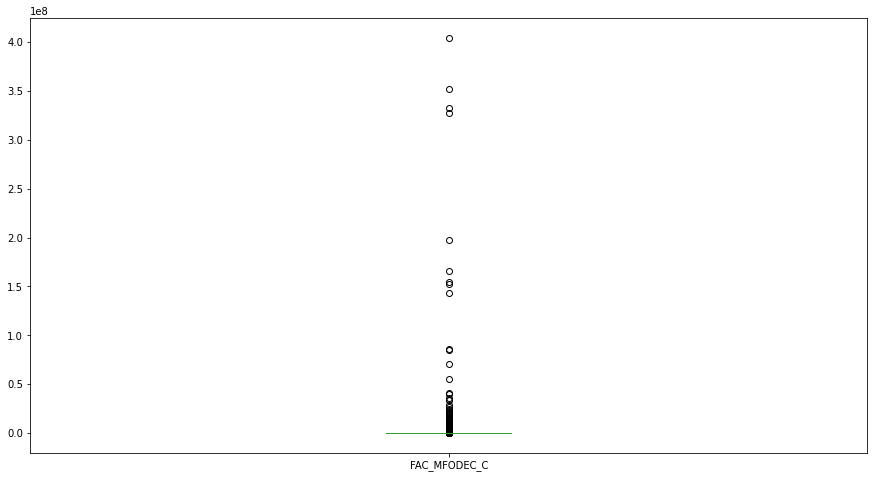

In [8]:
plt.figure(figsize=(15,8))
data['FAC_MFODEC_C'].plot(kind='box')
#for column in data:
# plt.figure()
# data.boxplot(column)

In [9]:
# This function seperate the columns into the various data types
def data_types(dataframe):
  int_col = []
  continuous_col = []
  cat_col = []
  for column in train:
    if train[column].dtypes == 'int64':
      int_col.append(column)
    elif train[column].dtypes == 'float':
      continuous_col.append(column)
    else:
      cat_col.append(column)
  return int_col, continuous_col, cat_col

In [10]:
int_col, continuous_col, cat_col = data_types(data)

In [11]:
print('Ordinal Variables', len(int_col))
print('Continuous Variables',len(continuous_col))
print('Categorical Variables', len(cat_col))

Ordinal Variables 16
Continuous Variables 103
Categorical Variables 2


In [12]:
int_col

['BCT_CODBUR',
 'CTR_MATFIS',
 'FJU_CODFJU',
 'CTR_CESSAT',
 'ACT_CODACT',
 'CTR_OBLDIR',
 'CTR_OBLACP',
 'CTR_OBLRES',
 'CTR_OBLFOP',
 'CTR_OBLTFP',
 'CTR_OBLDCO',
 'CTR_OBLTVA',
 'CTR_OBLTCL',
 'CTR_RATISS',
 'EXE_EXERCI',
 'RES_ANNIMP']

In [13]:
#data1 = data.drop(["CTR_CATEGO_X","id"], axis=1)
#int_col = pd.DataFrame(int_col, columns =['BCT_CODBUR','CTR_MATFIS','FJU_CODFJU','CTR_CESSAT','ACT_CODACT','CTR_OBLDIR','CTR_OBLACP','CTR_OBLRES','CTR_OBLFOP','CTR_OBLTFP','CTR_OBLDCO','CTR_OBLTVA','CTR_OBLTCL','CTR_RATISS','EXE_EXERCI','RES_ANNIMP'])
#plt.figure(figsize=(20,10))
#plt.boxplot(int_col)

In [14]:
data[int_col].describe()

,BCT_CODBUR,CTR_MATFIS,FJU_CODFJU,CTR_CESSAT,ACT_CODACT,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,CTR_OBLTFP,CTR_OBLDCO,CTR_OBLTVA,CTR_OBLTCL,CTR_RATISS,EXE_EXERCI,RES_ANNIMP
count,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000
mean,215.855546,7816.644315,59.239969,0.049181,4825.815945,4.453700,1.960121,1.976572,1.927669,1.948702,1.005206,2.039289,2.983236,0.022144,2014.516243,2014.516243
std,163.139993,4489.238442,38.531542,0.230543,1165.478787,1.204495,0.195679,0.155336,0.263688,0.223267,0.071967,0.194285,0.182054,0.209280,1.336841,1.336841
min,9.000000,1.000000,10.000000,0.000000,1002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,2013.000000,2013.000000
25%,92.000000,3949.000000,22.000000,0.000000,4203.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,0.000000,2013.000000,2013.000000
50%,192.000000,7851.500000,23.000000,0.000000,4417.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,0.000000,2014.000000,2014.000000
75%,254.000000,11710.250000,99.000000,0.000000,6102.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,0.000000,2015.000000,2015.000000
max,700.000000,15603.000000,99.000000,2.000000,8999.000000,9.000000,2.000000,5.000000,5.000000,3.000000,2.000000,3.000000,3.000000,2.000000,2018.000000,2018.000000


In [15]:
data[int_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28812 entries, 0 to 7516
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   BCT_CODBUR  28812 non-null  int64
 1   CTR_MATFIS  28812 non-null  int64
 2   FJU_CODFJU  28812 non-null  int64
 3   CTR_CESSAT  28812 non-null  int64
 4   ACT_CODACT  28812 non-null  int64
 5   CTR_OBLDIR  28812 non-null  int64
 6   CTR_OBLACP  28812 non-null  int64
 7   CTR_OBLRES  28812 non-null  int64
 8   CTR_OBLFOP  28812 non-null  int64
 9   CTR_OBLTFP  28812 non-null  int64
 10  CTR_OBLDCO  28812 non-null  int64
 11  CTR_OBLTVA  28812 non-null  int64
 12  CTR_OBLTCL  28812 non-null  int64
 13  CTR_RATISS  28812 non-null  int64
 14  EXE_EXERCI  28812 non-null  int64
 15  RES_ANNIMP  28812 non-null  int64
dtypes: int64(16)
memory usage: 3.7 MB


In [16]:
data[cat_col].head()

,CTR_CATEGO_X,id
0,C,train_id17437
1,M,train_id5086
2,M,train_id1443
3,C,train_id15469
4,M,train_id14368


In [17]:
data[continuous_col].describe()

,CTR_OFODEC,CTR_OFODEP,CTR_OFODET,CTR_OBLAUT,CTR_OBLASS,CTR_ODTIMB,CTR_OBLTHO,CTR_OBLDLI,CTR_OBLTVI,TVA_CHAFF6,...,AX5_MNTMAR,target,FAC_MNTPRI_F,FAC_MFODEC_F,FAC_MNTDCO_F,FAC_MNTTVA_F,FAC_MNTPRI_C,FAC_MFODEC_C,FAC_MNTDCO_C,FAC_MNTTVA_C
count,28801.000000,28801.000000,28801.000000,28801.000000,28801.000000,28801.000000,28801.000000,28801.000000,28801.000000,2.656700e+04,...,2.184300e+04,21295.000000,2.479000e+03,2.479000e+03,2.479000e+03,2.479000e+03,2.865000e+03,2.865000e+03,2.865000e+03,2.865000e+03
mean,1.091872,1.003368,1.017222,1.019756,1.000069,1.475122,1.012743,1.037568,1.002118,1.773663e+08,...,1.030642e+09,11.780084,8.243376e+09,5.433622e+06,6.729353e+05,4.461729e+08,8.660866e+08,1.359557e+06,2.469147e+04,1.414242e+08
std,0.288850,0.057937,0.130099,0.139164,0.008333,0.499389,0.112164,0.190153,0.045974,2.172927e+09,...,8.053263e+09,7.085772,1.175995e+11,1.793214e+08,1.933025e+07,4.105284e+09,4.265450e+09,1.535796e+07,6.111973e+05,7.400228e+08
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,...,0.000000e+00,0.000000,9.290000e+02,0.000000e+00,0.000000e+00,0.000000e+00,4.910000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,...,0.000000e+00,0.000000,2.993120e+07,0.000000e+00,0.000000e+00,4.323436e+06,1.957640e+07,0.000000e+00,0.000000e+00,3.021017e+06
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,...,4.857380e+06,14.981121,1.891549e+08,0.000000e+00,0.000000e+00,2.806525e+07,5.722739e+07,0.000000e+00,0.000000e+00,8.882093e+06
75%,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000e+00,...,1.600982e+08,16.625623,9.674418e+08,0.000000e+00,0.000000e+00,1.459402e+08,2.754562e+08,0.000000e+00,0.000000e+00,4.449364e+07
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.060280e+11,...,6.939760e+11,23.591334,3.414510e+12,8.897885e+09,8.212377e+08,1.608780e+11,8.394391e+10,4.044067e+08,2.614500e+07,1.510990e+10


In [18]:
# Function to handle missing values
def missing_values(data, threshold = 70.0):
    drop_columns = []
    keep_columns = []
    columns = data.columns 
    for column in columns:
        missing_val_percent = (100 * data[column].isna().sum() / len(data))
        if missing_val_percent >= threshold:
            drop_columns.append(column)
        else:
            keep_columns.append(column)
    return (drop_columns, keep_columns)

In [19]:
# Columns to drop and those to keep due to missing values
drop_columns , keep_columns = missing_values(data)

print('Number of columns with more than 70% missing values:', len(drop_columns))
print('Number of columns to keep:', len(keep_columns))

Number of columns with more than 70% missing values: 30
Number of columns to keep: 91


In [20]:
print(drop_columns)

['ADB_MNTORD', 'SND_MNTPRD_I', 'SND_MNTTVA_I', 'SND_MNTDRC_I', 'SND_MNTAVA_I', 'SND_MNTTAX_I', 'SND_MNTPAY_I', 'SND_MNTAIR_I', 'SND_MNTPRD_E', 'SND_MNTTVA_E', 'SND_MNTDRC_E', 'SND_MNTAVA_E', 'SND_MNTTAX_E', 'SND_MNTPAY_E', 'SND_MNTAIR_E', 'SND_MNTPRD_A', 'SND_MNTTVA_A', 'SND_MNTDRC_A', 'SND_MNTAVA_A', 'SND_MNTTAX_A', 'SND_MNTPAY_A', 'SND_MNTAIR_A', 'FAC_MNTPRI_F', 'FAC_MFODEC_F', 'FAC_MNTDCO_F', 'FAC_MNTTVA_F', 'FAC_MNTPRI_C', 'FAC_MFODEC_C', 'FAC_MNTDCO_C', 'FAC_MNTTVA_C']


In [21]:
#data[keep_columns].dtypes('int64')

In [22]:
# Columns to keep 
data[keep_columns].head()

,BCT_CODBUR,CTR_MATFIS,CTR_CATEGO_X,FJU_CODFJU,CTR_CESSAT,ACT_CODACT,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,...,TVA_CA132018,TVA_CA192018,AX1_BRTIMP,AX2_HONORA,AX2_LOYERS,AX3_REVCAP,AX5_MNTMAR,RES_ANNIMP,target,id
0,44,6210,C,99,0,3707,4,2,2,2,...,0.0,0.0,0.0,2950000.0,0.0,0.0,602769328.0,2014,16.639203,train_id17437
1,401,14383,M,22,0,6105,4,2,2,2,...,0.0,0.0,0.0,203353885.0,0.0,0.0,14785200.0,2013,17.827703,train_id5086
2,243,11555,M,23,0,5751,4,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,10792800.0,2013,15.473503,train_id1443
3,72,6175,C,99,0,4402,4,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,0.000000,train_id15469
4,42,1417,M,23,0,6302,4,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,14.286244,train_id14368


In [23]:
data1 = data[keep_columns]

In [24]:
def columns_type(data):
    cat_var =[]
    inte_var = []
    flo_var = []
    for column in data1.columns:
        if data1[column].dtypes == 'int64':
            inte_var.append(column)
        elif data1[column].dtypes == 'object':
            cat_var.append(column)
        else:
            flo_var.append(column)
    return cat_var,inte_var,flo_var

In [25]:
cat_var,inte_var,flo_var = columns_type(keep_columns)

In [26]:
print("The length of Continuos variables is ", len(flo_var))
print("The length of integers is ", len(inte_var))
print("The length of categoriacl variables is ", len(cat_var))
print("Total columns is ", len(flo_var) + len(inte_var) + len(cat_var))

The length of Continuos variables is  73
The length of integers is  16
The length of categoriacl variables is  2
Total columns is  91


### Since the values didn't change, we can go ahead with the general missing values. We wanted to be specific to the data type using the keep_columns

### All the values in some variables are only zeros. 

In [27]:
col_only_zeros = []
for column in continuous_col:
    if data[column].max() == 0 and data[column].min() == 0:
        col_only_zeros.append(column)

print(len(col_only_zeros))
print(col_only_zeros)

11
['TVA_CAF125', 'TVA_CHAF36', 'TVA_MTORDTAX', 'TVA_MTDJRTAX', 'TVA_MTRESTAX', 'SND_MNTAVA_I', 'SND_MNTTVA_E', 'SND_MNTDRC_E', 'SND_MNTAVA_E', 'SND_MNTAIR_E', 'SND_MNTAVA_A']


In [28]:
print(drop_columns)

['ADB_MNTORD', 'SND_MNTPRD_I', 'SND_MNTTVA_I', 'SND_MNTDRC_I', 'SND_MNTAVA_I', 'SND_MNTTAX_I', 'SND_MNTPAY_I', 'SND_MNTAIR_I', 'SND_MNTPRD_E', 'SND_MNTTVA_E', 'SND_MNTDRC_E', 'SND_MNTAVA_E', 'SND_MNTTAX_E', 'SND_MNTPAY_E', 'SND_MNTAIR_E', 'SND_MNTPRD_A', 'SND_MNTTVA_A', 'SND_MNTDRC_A', 'SND_MNTAVA_A', 'SND_MNTTAX_A', 'SND_MNTPAY_A', 'SND_MNTAIR_A', 'FAC_MNTPRI_F', 'FAC_MFODEC_F', 'FAC_MNTDCO_F', 'FAC_MNTTVA_F', 'FAC_MNTPRI_C', 'FAC_MFODEC_C', 'FAC_MNTDCO_C', 'FAC_MNTTVA_C']


In [29]:
drop_col = ['SND_MNTAVA_I','SND_MNTTVA_E','SND_MNTDRC_E','SND_MNTAVA_E','SND_MNTAIR_E','SND_MNTAVA_A']

In [30]:
remove_columns = col_only_zeros + drop_col

In [31]:
len(remove_columns)

17

In [32]:
data2 = data.drop(remove_columns, axis=1)

In [33]:
len(data2.columns)

110

In [34]:
data2.isnull().sum()

BCT_CODBUR          0
CTR_MATFIS          0
CTR_CATEGO_X        0
FJU_CODFJU          0
CTR_CESSAT          0
                ...  
FAC_MNTPRI_C    25947
FAC_MFODEC_C    25947
FAC_MNTDCO_C    25947
FAC_MNTTVA_C    25947
id                  0
Length: 110, dtype: int64

In [35]:
data2 = data2.drop(['id','target'],axis=1)

In [36]:
#np.percentile(data,25)

In [37]:
data2.head()

,BCT_CODBUR,CTR_MATFIS,CTR_CATEGO_X,FJU_CODFJU,CTR_CESSAT,ACT_CODACT,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,...,AX5_MNTMAR,RES_ANNIMP,FAC_MNTPRI_F,FAC_MFODEC_F,FAC_MNTDCO_F,FAC_MNTTVA_F,FAC_MNTPRI_C,FAC_MFODEC_C,FAC_MNTDCO_C,FAC_MNTTVA_C
0,44,6210,C,99,0,3707,4,2,2,2,...,602769328.0,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,401,14383,M,22,0,6105,4,2,2,2,...,14785200.0,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,243,11555,M,23,0,5751,4,2,2,2,...,10792800.0,2013,25387000.0,0.0,0.0,4571280.0,NaN,NaN,NaN,NaN
3,72,6175,C,99,0,4402,4,2,2,2,...,0.0,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,42,1417,M,23,0,6302,4,2,2,2,...,0.0,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28812 entries, 0 to 7516
Columns: 108 entries, BCT_CODBUR to FAC_MNTTVA_C
dtypes: float64(91), int64(16), object(1)
memory usage: 24.0+ MB


In [39]:
data2.CTR_CATEGO_X.unique()

array(['C', 'M', 'P', 'N'], dtype=object)

In [40]:
data2 = pd.get_dummies(data2)
#data2['CTR_CATEGO_X'] = data2['CTR_CATEGO_X'].replace({'C':1, 'M':2, 'P':3, 'N':4})

In [41]:
data2.head()

,BCT_CODBUR,CTR_MATFIS,FJU_CODFJU,CTR_CESSAT,ACT_CODACT,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,CTR_OBLTFP,...,FAC_MNTDCO_F,FAC_MNTTVA_F,FAC_MNTPRI_C,FAC_MFODEC_C,FAC_MNTDCO_C,FAC_MNTTVA_C,CTR_CATEGO_X_C,CTR_CATEGO_X_M,CTR_CATEGO_X_N,CTR_CATEGO_X_P
0,44,6210,99,0,3707,4,2,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
1,401,14383,22,0,6105,4,2,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
2,243,11555,23,0,5751,4,2,2,2,2,...,0.0,4571280.0,NaN,NaN,NaN,NaN,0,1,0,0
3,72,6175,99,0,4402,4,2,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
4,42,1417,23,0,6302,4,2,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0


In [42]:
def columns_with_outliers(data, threshold = 1.5):
  columns = data.columns
  outlier_columns = []
  no_outliers_col = []
  for column in columns:
    q1 = np.percentile(data[column], 25)
    q3 = np.percentile(data[column], 75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    for i in range(len(data[column])):
      if ((data[column][i]) < lower_bound) or ((data[column][i]) > lower_bound):
        #if column not in outlier_columns:
        outlier_columns.append(column)
      else:
        no_outliers_col.append(column)
  return outlier_columns, no_outliers_col

In [43]:
outlier_columns, no_outliers_col = columns_with_outliers(data2)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [44]:
null_col = []
for column in data2.columns:
    if data2[column].count() != 28812:
        null_col.append(column)

In [45]:
print(null_col)

['CTR_OFODEC', 'CTR_OFODEP', 'CTR_OFODET', 'CTR_OBLAUT', 'CTR_OBLASS', 'CTR_ODTIMB', 'CTR_OBLTHO', 'CTR_OBLDLI', 'CTR_OBLTVI', 'TVA_CHAFF6', 'TVA_CHAFF7', 'TVA_CHAF10', 'TVA_CHAF12', 'TVA_CHAF15', 'TVA_CHAF18', 'TVA_CHAF22', 'TVA_CHAF29', 'TVA_TOTDUE', 'TVA_MOIDEB', 'TVA_CRDINI', 'TVA_BASIMB', 'TVA_DEDIMB', 'TVA_BASEQL', 'TVA_DEDEQL', 'TVA_BASEQI', 'TVA_DEDEQI', 'TVA_BASAUL', 'TVA_DEDAUL', 'TVA_BASAUI', 'TVA_DEDAUI', 'TVA_BASRSM', 'TVA_DEDRSM', 'TVA_RSNRES', 'TVA_TRSPOR', 'TVA_DEDREG', 'TVA_RESTIT', 'TVA_MNTPAY', 'TVA_MOIFIN', 'TVA_CRDFIN', 'TVA_ACHSUS', 'TVA_ACHEXO', 'TVA_ACHNDD', 'TVA_CAFEXP', 'TVA_CAFSUS', 'TVA_CAFEXO', 'TVA_AACHAB', 'TVA_CRDBLQ', 'TVA_CRDRES', 'TVA_CRDRMP', 'TVA_CRDREP', 'TVA_CRDRMC', 'TVA_MACHN', 'TVA_MCESQ', 'TVA_MTVLSM', 'TVA_TXVLSM', 'TVA_MTALSM', 'TVA_TXALSM', 'TVA_MTORDTVA', 'TVA_MTDJRTVA', 'TVA_CA072018', 'TVA_CA132018', 'TVA_CA192018', 'ADB_MNTORD', 'SND_MNTPRD_I', 'SND_MNTTVA_I', 'SND_MNTDRC_I', 'SND_MNTTAX_I', 'SND_MNTPAY_I', 'SND_MNTAIR_I', 'SND_MNTPRD_E

In [46]:
def fill_nulls(value):
    cols_fill = ['CTR_OFODEC', 'CTR_OFODEP', 'CTR_OFODET', 'CTR_OBLAUT', 'CTR_OBLASS', 'CTR_ODTIMB', 'CTR_OBLTHO', 'CTR_OBLDLI', 'CTR_OBLTVI', 'TVA_CHAFF6', 'TVA_CHAFF7', 'TVA_CHAF10', 'TVA_CHAF12', 'TVA_CHAF15',
                 'TVA_CHAF18', 'TVA_CHAF22', 'TVA_CHAF29', 'TVA_TOTDUE', 'TVA_MOIDEB', 'TVA_CRDINI', 'TVA_BASIMB', 'TVA_DEDIMB', 'TVA_BASEQL', 'TVA_DEDEQL', 'TVA_BASEQI', 'TVA_DEDEQI', 'TVA_BASAUL', 'TVA_DEDAUL', 
                 'TVA_BASAUI', 'TVA_DEDAUI', 'TVA_BASRSM', 'TVA_DEDRSM', 'TVA_RSNRES', 'TVA_TRSPOR', 'TVA_DEDREG', 'TVA_RESTIT', 'TVA_MNTPAY', 'TVA_MOIFIN', 'TVA_CRDFIN', 'TVA_ACHSUS', 'TVA_ACHEXO', 'TVA_ACHNDD',
                 'TVA_CAFEXP', 'TVA_CAFSUS', 'TVA_CAFEXO', 'TVA_AACHAB', 'TVA_CRDBLQ', 'TVA_CRDRES', 'TVA_CRDRMP', 'TVA_CRDREP', 'TVA_CRDRMC', 'TVA_MACHN', 'TVA_MCESQ', 'TVA_MTVLSM', 'TVA_TXVLSM', 'TVA_MTALSM', 
                 'TVA_TXALSM', 'TVA_MTORDTVA', 'TVA_MTDJRTVA', 'TVA_CA072018', 'TVA_CA132018', 'TVA_CA192018', 'AX1_BRTIMP', 'AX2_HONORA', 'AX2_LOYERS', 'AX3_REVCAP', 'AX5_MNTMAR',
                'ADB_MNTORD', 'SND_MNTPRD_I', 'SND_MNTTVA_I', 'SND_MNTDRC_I', 'SND_MNTTAX_I', 'SND_MNTPAY_I', 'SND_MNTAIR_I', 'SND_MNTPRD_E',
                 'SND_MNTTAX_E', 'SND_MNTPAY_E', 'SND_MNTPRD_A', 'SND_MNTTVA_A', 'SND_MNTDRC_A', 'SND_MNTTAX_A', 'SND_MNTPAY_A', 'SND_MNTAIR_A', 'FAC_MNTPRI_F', 'FAC_MFODEC_F',
                 'FAC_MNTDCO_F', 'FAC_MNTTVA_F', 'FAC_MNTPRI_C', 'FAC_MFODEC_C', 'FAC_MNTDCO_C', 'FAC_MNTTVA_C']
    
    if value == -9999:
        for col in cols_fill:
            data2.loc[data2[col].isnull(), col] = -9999
    else : 
        for col in cols_fill:
            data2.loc[data2[col].isnull(), col] = data2[col].median()

In [47]:
#data.SND_MNTAVA_I.unique 'SND_MNTAVA_A',

In [48]:
fill_nulls(-9999)

In [49]:
data2.isnull().sum()

BCT_CODBUR        0
CTR_MATFIS        0
FJU_CODFJU        0
CTR_CESSAT        0
ACT_CODACT        0
                 ..
FAC_MNTTVA_C      0
CTR_CATEGO_X_C    0
CTR_CATEGO_X_M    0
CTR_CATEGO_X_N    0
CTR_CATEGO_X_P    0
Length: 111, dtype: int64

In [50]:
data2.describe()

,BCT_CODBUR,CTR_MATFIS,FJU_CODFJU,CTR_CESSAT,ACT_CODACT,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,CTR_OBLTFP,...,FAC_MNTDCO_F,FAC_MNTTVA_F,FAC_MNTPRI_C,FAC_MFODEC_C,FAC_MNTDCO_C,FAC_MNTTVA_C,CTR_CATEGO_X_C,CTR_CATEGO_X_M,CTR_CATEGO_X_N,CTR_CATEGO_X_P
count,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,28812.000000,...,2.881200e+04,2.881200e+04,2.881200e+04,2.881200e+04,2.881200e+04,2.881200e+04,28812.000000,28812.000000,28812.000000,28812.000000
mean,215.855546,7816.644315,59.239969,0.049181,4825.815945,4.453700,1.960121,1.976572,1.927669,1.948702,...,4.876103e+04,3.837982e+07,8.611268e+07,1.261866e+05,-6.549459e+03,1.405390e+07,0.268465,0.515827,0.000278,0.215431
std,163.139993,4489.238442,38.531542,0.230543,1165.478787,1.204495,0.195679,0.155336,0.263688,0.223267,...,5.672267e+06,1.210452e+09,1.369592e+09,4.859494e+06,1.929825e+05,2.371281e+08,0.443168,0.499758,0.016661,0.411128
min,9.000000,1.000000,10.000000,0.000000,1002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,0.000000,0.000000,0.000000,0.000000
25%,92.000000,3949.000000,22.000000,0.000000,4203.000000,4.000000,2.000000,2.000000,2.000000,2.000000,...,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,0.000000,0.000000,0.000000,0.000000
50%,192.000000,7851.500000,23.000000,0.000000,4417.000000,4.000000,2.000000,2.000000,2.000000,2.000000,...,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,0.000000,1.000000,0.000000,0.000000
75%,254.000000,11710.250000,99.000000,0.000000,6102.000000,4.000000,2.000000,2.000000,2.000000,2.000000,...,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,1.000000,1.000000,0.000000,0.000000
max,700.000000,15603.000000,99.000000,2.000000,8999.000000,9.000000,2.000000,5.000000,5.000000,3.000000,...,8.212377e+08,1.608780e+11,8.394391e+10,4.044067e+08,2.614500e+07,1.510990e+10,1.000000,1.000000,1.000000,1.000000


## Checking outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x1f966d3cb20>,
 'caps': [<matplotlib.lines.Line2D at 0x1f966d240d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f966d3cfd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f966d24550>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f966d24f10>],
 'means': []}

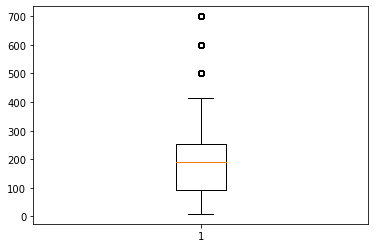

In [51]:
plt.boxplot(data2["BCT_CODBUR"])

In [52]:
data2.BCT_CODBUR.max()

700

In [53]:
Q1 = data2["BCT_CODBUR"].quantile(0.25)
Q3 = data2["BCT_CODBUR"].quantile(0.75)
IQR = Q1 - Q3
print(Q1)
print(Q3)
print(IQR)
Lower_Whisker = Q1 - 1.5*IQR
Upper_Whisker = Q3 + 1.5*IQR
print(Lower_Whisker, Upper_Whisker)

92.0
254.0
-162.0
335.0 11.0


In [54]:
out = data2["BCT_CODBUR"]<Lower_Whisker | data2["BCT_CODBUR"]>Upper_Whisker
med = data2["BCT_CODBUR"].median()
data2["BCT_CODBUR"] = data2["BCT_CODBUR"].replace(out:med,axis=1)

SyntaxError: invalid syntax (<ipython-input-54-1e879cf99c0c>, line 3)

In [55]:
threshold = 1.5
q1 = np.percentile(data2["BCT_CODBUR"], 25)
q3 = np.percentile(data2["BCT_CODBUR"], 75)
iqr = q3 - q1
lower_bound1 = q1 - threshold * iqr
upper_bound1 = q3 + threshold * iqr

In [56]:
upper_bound1

497.0

In [57]:
upper_bound

NameError: name 'upper_bound' is not defined

In [58]:
outlier = []
Q1 = data2["BCT_CODBUR"].quantile(0.25)
Q3 = data2["BCT_CODBUR"].quantile(0.75)
IQR = Q1 - Q3
lower_bound = (Q1-1.5)*IQR
upper_bound = (Q3+1.5)*IQR
equ = data2.index[data2["BCT_CODBUR"]<lower_bound | data2["BCT_CODBUR"]>upper_bound]
for i in data2["BCT_CODBUR"]:
    if i > upper_bound:
        data2["BCT_CODBUR"].replace({'i':data2["BCT_CODBUR"].median()}, axis=1)

TypeError: Cannot perform 'ror_' with a dtyped [int64] array and scalar of type [bool]

In [59]:
list_index = []
for column in data2.columns:
    list_index.extend(outliers(data2, column))

NameError: name 'outliers' is not defined

## Scaling the dataset

In [60]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_classif
#df = SelectKBest(f_classif, k=3)
#scaler = StandardScaler()
scaler = QuantileTransformer()
data_scale = scaler.fit_transform(data2)
data_sc_raw = pd.DataFrame(data_scale, columns = data2.columns)

In [61]:
data_sc_raw.head()

,BCT_CODBUR,CTR_MATFIS,FJU_CODFJU,CTR_CESSAT,ACT_CODACT,CTR_OBLDIR,CTR_OBLACP,CTR_OBLRES,CTR_OBLFOP,CTR_OBLTFP,...,FAC_MNTDCO_F,FAC_MNTTVA_F,FAC_MNTPRI_C,FAC_MFODEC_C,FAC_MNTDCO_C,FAC_MNTTVA_C,CTR_CATEGO_X_C,CTR_CATEGO_X_M,CTR_CATEGO_X_N,CTR_CATEGO_X_P
0,0.108108,0.394967,1.000000,0.0,0.147153,0.432432,1.0,0.511512,0.536537,0.525526,...,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.802302,0.925051,0.275275,0.0,0.765766,0.432432,1.0,0.511512,0.536537,0.525526,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.669670,0.739410,0.483984,0.0,0.708709,0.432432,1.0,0.511512,0.536537,0.525526,...,0.956957,0.936221,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.208208,0.392558,1.000000,0.0,0.448949,0.432432,1.0,0.511512,0.536537,0.525526,...,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.095095,0.089339,0.483984,0.0,0.879880,0.432432,1.0,0.511512,0.536537,0.525526,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [62]:
#Train and test datasets
train = data_sc_raw[:ntrain].copy()
test = data_sc_raw[ntrain:].copy()
test = test.reset_index(drop=True)

In [63]:
print('train:',train.shape)
print('test:', test.shape)

train: (21295, 111)
test: (7517, 111)


In [67]:
# lightgbm for regression
from numpy import mean
from numpy import std
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot

# evaluate the model
model_lg = LGBMRegressor()
model_lg = model_lg.fit(train, target)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_lg, train, target, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print('LGBM MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset

LGBM MSE: -34.814 (1.261)


In [69]:
y_pred_lg = model_lg.predict(test)
y_pred_lg

array([16.09781298, 15.05271775, 12.52348935, ..., 15.14428878,
       10.9020936 , 14.1610393 ])

In [ ]:
from catboost import CatBoostRegressor
model_c = CatBoostRegressor(verbose=0, n_estimators=100)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_c, train, target, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print('CAT MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model_cat = CatBoostRegressor(verbose=0, n_estimators=100)
model_cat.fit(train, target)

In [ ]:
model_cat = model_cat.predict(test)

In [75]:
# evaluate the model
from xgboost import XGBRegressor
model_xg = XGBRegressor(objective='reg:squarederror')
model_xg =   model_xg.fit(train, target)
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(model_xg, train, target, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print('XGBM MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
#model_xg = XGBRegressor(objective='reg:squarederror')

XGBM MSE: -35.146 (1.256)


In [76]:
y_pred_xg = model_xg.predict(test)
y_pred_xg

array([17.756594, 15.297316, 12.024465, ..., 15.888806, 12.384665,
       17.545317], dtype=float32)

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
#from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

In [ ]:
# make a prediction with a stacking mlxtend
from sklearn.linear_model import LinearRegression
#import mlxtend
#from sklearn.ensemble import StackingRegressor
from mlxtend.regressor import StackingRegressor

# define meta learner model
lin_reg = LinearRegression()
# define the stacking ensemble
model_st = StackingRegressor(regressors=[model_lg, model_cat, model_xg], meta_regressor=lin_reg)
# fit the model on all available data
model_st.fit(train, target)
stack_result = model_st.predict(test)

In [ ]:
#stact_result_prob = model_st.predict_meta_features(test)

In [ ]:
#stact_result_prob

In [ ]:
#stack_result

In [71]:
Submission['target'] = y_pred_lg #model_lg.predict(test) 
file_name = 'submission_eli.csv'
Submission.to_csv(file_name ,index=False)

In [ ]:
Submission['target'] = model_cat #model_lg.predict(test) 
file_name = 'Catboost111-raw.csv'
Submission.to_csv(file_name ,index=False)

In [77]:
Submission['target'] = y_pred_xg #model_lg.predict(test) 
file_name = 'XGBoost_eli.csv'
Submission.to_csv(file_name ,index=False)